In [2]:
import os 
from pyMFI import MFI
import scipy
from pyMFI import MFI1D
from pyMFI import run_plumed

import numpy as np
import pickle
import matplotlib.pyplot as plt
import glob
import sys

#Analytical surface
x = np.linspace(-2, 2, 201)
y = 7*x**4-23*x**2
y = y - min(y)

os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")

## Run WT-MetaD simulation

In [4]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")
os.system("rm analysis.*")
os.system("rm fes.dat")
os.system("rm bck.*")

simulation_steps = 1000000
run_plumed.run_langevin1D_plumed_fes(length = simulation_steps, initial_position=1.7, sigma=0.1, height=1, biasfactor=10, fes_stride = int(simulation_steps/100))

os.system("rm bck.*")

Running simulation


0

## Analyse with MFI

10.0%   OFE = 9.2258
20.0%   OFE = 9.2387
30.0%   OFE = 9.2482
40.0%   OFE = 9.208
50.0%   OFE = 9.0954
60.0%   OFE = 9.0463
70.0%   OFE = 9.0128
80.0%   OFE = 8.9927
90.0%   OFE = 8.9432
100.0%   OFE = 8.9119


Text(0.5, 0, 'Simulation time [ns]')

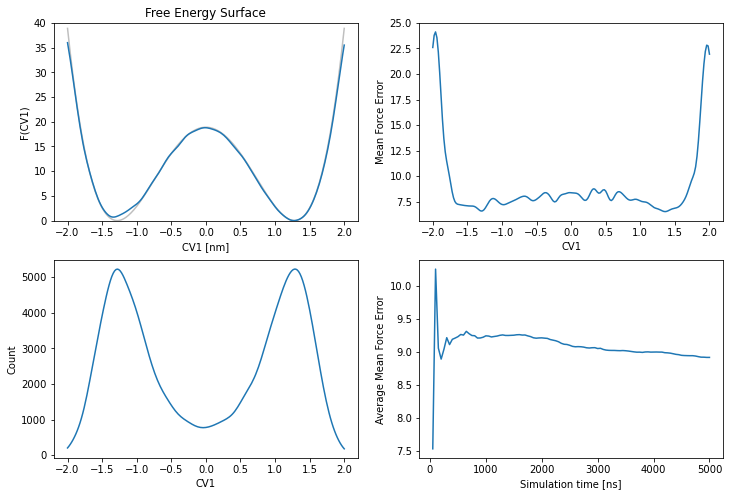

In [11]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")

#Read the HILLS file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")

#Read the Colvar File
position = MFI1D.load_position(position_name="position")

#Compute the time-independent mean force
[X, Ftot_den, Ftot, ofv, ofe, ofv_history, ofe_history, time_history, intermediate_fes_list] = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.1, kT = 1, min_grid=-2, 
                                                         max_grid=2, nbins=201, log_pace=10, error_pace=100, WellTempered=1, intermediate_fes_number=100)


# Integrate Ftot, obtain FES 
FES = MFI1D.intg_1D(X,Ftot)

# Plot Recap
lim=40
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(x, y, c="grey", alpha=0.5)
axs[0, 0].plot(X, FES)
axs[0, 0].set_ylim([0, lim])
axs[0, 0].set_ylabel('F(CV1)')
axs[0, 0].set_xlabel('CV1 [nm]')
axs[0, 0].set_title('Free Energy Surface')

axs[0, 1].plot(X, ofe);
axs[0, 1].set_ylabel('Mean Force Error')
axs[0, 1].set_xlabel('CV1')

axs[1, 0].plot(X, Ftot_den);
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_xlabel('CV1')

axs[1, 1].plot(time_history, ofe_history);
axs[1, 1].set_ylabel('Average Mean Force Error')
axs[1, 1].set_xlabel('Simulation time [ns]')

0


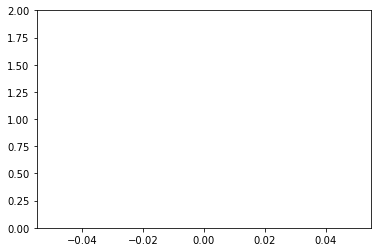

In [13]:
print(len(intermediate_fes_list))

AAD_progression = []
for i in range(len(intermediate_fes_list)):
    AAD_progression.append(sum(abs(y - intermediate_fes_list[i]))/len(y))
    
plt.plot(range(len(AAD_progression)), AAD_progression)
plt.scatter(range(len(AAD_progression)), AAD_progression, s=2)
plt.ylim(0,2)
plt.show()

error_progression_MFI = AAD_progression
    

## Analyse with REWEIGHT_METAD

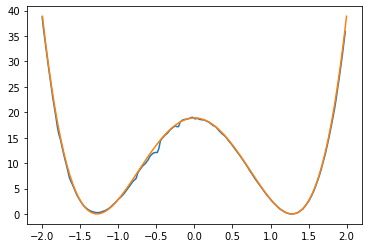

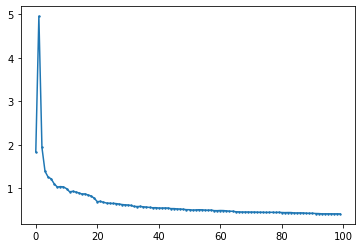

In [7]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")
error_progression = []

for filen in sorted(glob.glob( "analysis.*." + "fes.dat" ), key=os.path.getmtime) :
    data = np.loadtxt( filen )
    grid_data = data[:,0][50:251]
    fes_data = data[:,1][50:251]
    fes_data = fes_data - min(fes_data)
    diff = np.where(abs(fes_data) < 10**4, abs(y - fes_data), 0)
    error_progression.append((sum(diff)/np.count_nonzero(diff)))
    
plt.plot(grid_data, fes_data)
plt.plot(x,y)
plt.show()  
         
for filen in glob.glob("fes.dat"):
    data = np.loadtxt( filen )
    grid_data = data[:,0][50:251]
    fes_data = data[:,1][50:251]
    fes_data = fes_data - min(fes_data)
    error_progression.append((sum(abs(y - fes_data))/len(y)))
    

    
plt.plot(range(len(error_progression)), error_progression)
plt.scatter(range(len(error_progression)), error_progression, s=2)
plt.show()

error_progression_wt_metad = error_progression


## Alalyse with sum_hills

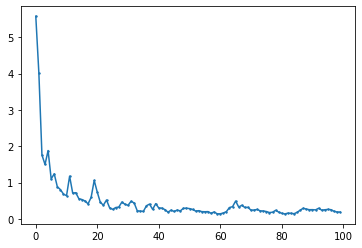

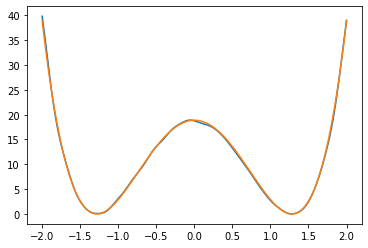

In [8]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well/sum_hills")

os.system("plumed sum_hills --hills HILLS --stride 101 --min -2.0 --max 2.0 --bin 200")

error_progression = []

for filen in sorted(glob.glob( "fes_*.dat" ), key=os.path.getmtime) :
    data = np.loadtxt( filen )
    grid_data = data[:,0]
    fes_data = data[:,1]
    fes_data = fes_data - min(fes_data)
    diff = np.where(abs(fes_data) < 10**4, abs(y - fes_data), 0)
    error_progression.append((sum(diff)/np.count_nonzero(diff)))
    
plt.plot(range(len(error_progression)), error_progression)
plt.scatter(range(len(error_progression)), error_progression, s=2)
plt.show()

plt.plot(grid_data, fes_data)
plt.plot(x,y)
plt.show()  

error_progression_wt_sumhills = error_progression

os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")

## Run (non-WT) MetaD simulation

In [18]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well/non_WT")
os.system("rm analysis.*")
os.system("rm fes.dat")
os.system("rm bck.*")

simulation_steps = 1000000
run_plumed.run_langevin1D_plumed_fes(length = simulation_steps, sigma=0.1, height=1, biasfactor=10**4, fes_stride = int(simulation_steps/100), grid_min=-4, grid_max=4, grid_bin=400)

os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")

Running simulation


## Analyse with MFI

10.0%   OFE = 1.3079
20.0%   OFE = 0.9173
30.0%   OFE = 0.7749
40.0%   OFE = 0.706
50.0%   OFE = 0.6438
60.0%   OFE = 0.5915
70.0%   OFE = 0.549
80.0%   OFE = 0.5212
90.0%   OFE = 0.49
100.0%   OFE = 0.4686


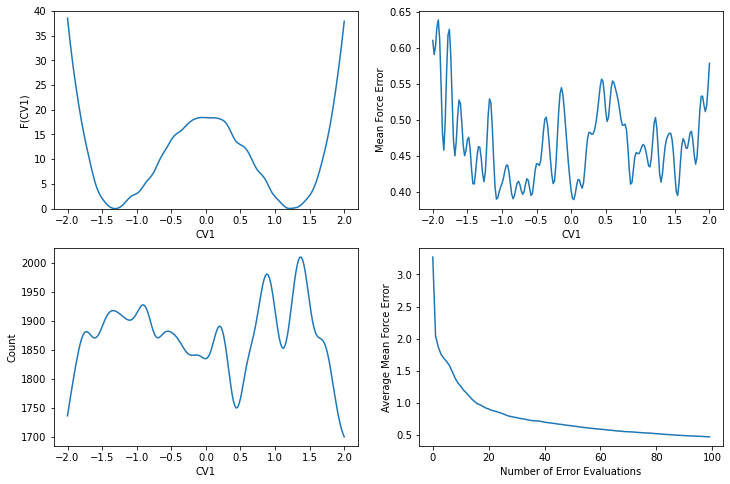

100


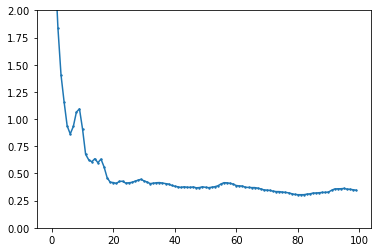

In [19]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well/non_WT")

#Read the HILLS file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")

#Read the Colvar File
position = MFI1D.load_position(position_name="position")

#Compute the time-independent mean force
[X, Ftot_den, Ftot, ofe, ofe_history, intermediate_fes_list] = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.1, kT = 1, min_grid=-2, max_grid=2, nbins=201, log_pace=10, error_pace=100, WellTempered=0, intermediate_fes_number=100)


# Integrate Ftot, obtain FES 
FES = MFI1D.intg_1D(X,Ftot)

# Plot Recap
MFI1D.plot_recap(X, FES, Ftot_den, ofe, ofe_history)
plt.show()

print(len(intermediate_fes_list))

AAD_progression_non_WT = []
for i in range(len(intermediate_fes_list)):
    AAD_progression_non_WT.append(sum(abs(y - intermediate_fes_list[i]))/len(y))
    
plt.plot(range(len(AAD_progression_non_WT)), AAD_progression_non_WT)
plt.scatter(range(len(AAD_progression_non_WT)), AAD_progression_non_WT, s=2)
plt.ylim(0,2)
plt.show()

error_progression_MFI_non_WT = AAD_progression_non_WT

## Analyse with Reweight MetaD

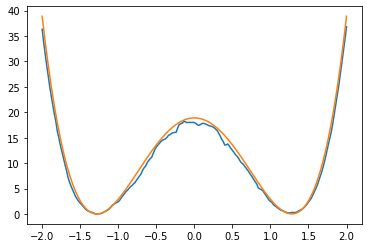

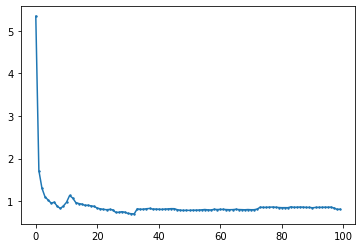

In [20]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well/non_WT")


error_progression = []

for filen in sorted(glob.glob( "analysis.*." + "fes.dat" ), key=os.path.getmtime) :
    data = np.loadtxt( filen ) 
    grid_data = data[:,0][100:301]
    fes_data = data[:,1][100:301]
    fes_data = fes_data - min(fes_data)
    diff = np.where(abs(fes_data) < 10**4, abs(y - fes_data), 0)
    error_progression.append((sum(diff)/np.count_nonzero(diff)))
    
for filen in glob.glob("fes.dat"):
    data = np.loadtxt( filen )
    grid_data = data[:,0][100:301]
    fes_data = data[:,1][100:301]
    fes_data = fes_data - min(fes_data)
    error_progression.append((sum(abs(y - fes_data))/len(y)))
    
    plt.plot(grid_data, fes_data)
    plt.plot(x, y)
    plt.show()
    
plt.plot(range(len(error_progression)), error_progression)
plt.scatter(range(len(error_progression)), error_progression, s=2)
plt.show()

error_progression_metad = error_progression



os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/1D_double_well")

## Plot all

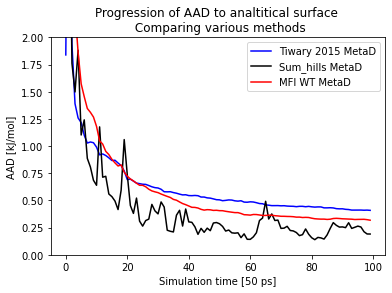

In [30]:
# plt.plot(range(len(error_progression_metad)), error_progression_metad, label="Tiwary 2015 Non-WT MetaD", color="cyan")
plt.plot(range(len(error_progression_wt_metad)), error_progression_wt_metad, label="Tiwary 2015 MetaD", color="blue")
# plt.plot(range(len(error_progression_MFI_non_WT)), error_progression_MFI_non_WT, label="MFI Non-WT MetaD", color="blue")
plt.plot(range(len(error_progression_wt_sumhills)), error_progression_wt_sumhills, label="Sum_hills MetaD", color="black")
plt.plot(range(len(error_progression_MFI)), error_progression_MFI, label="MFI WT MetaD", color="red")
plt.legend()
plt.xlabel("Simulation time [50 ps]")
plt.ylabel("AAD [kJ/mol]")
plt.title("Progression of AAD to analtitical surface \n Comparing various methods")
plt.ylim(0,2)
plt.show()

In [10]:
results_path = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/results_plot"

MFI.save_pkl([x, y, FES, ofe], "mfi_results.pkl")
MFI.save_pkl([error_progression_wt_metad, error_progression_wt_sumhills, error_progression_MFI], "error_progression.pkl")



NameError: name 'error_progression_MFI' is not defined